In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf

In [ ]:
# Simulate time series
sin = np.sin(np.linspace(0,100,1000))

# Compute the pvalue
p = adfuller(sin)[1]


plt.figure(figsize=(15,8))
plt.plot(sin, color="#035593", linewidth=3)
plt.title(f"P-value: {p}", size=20)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

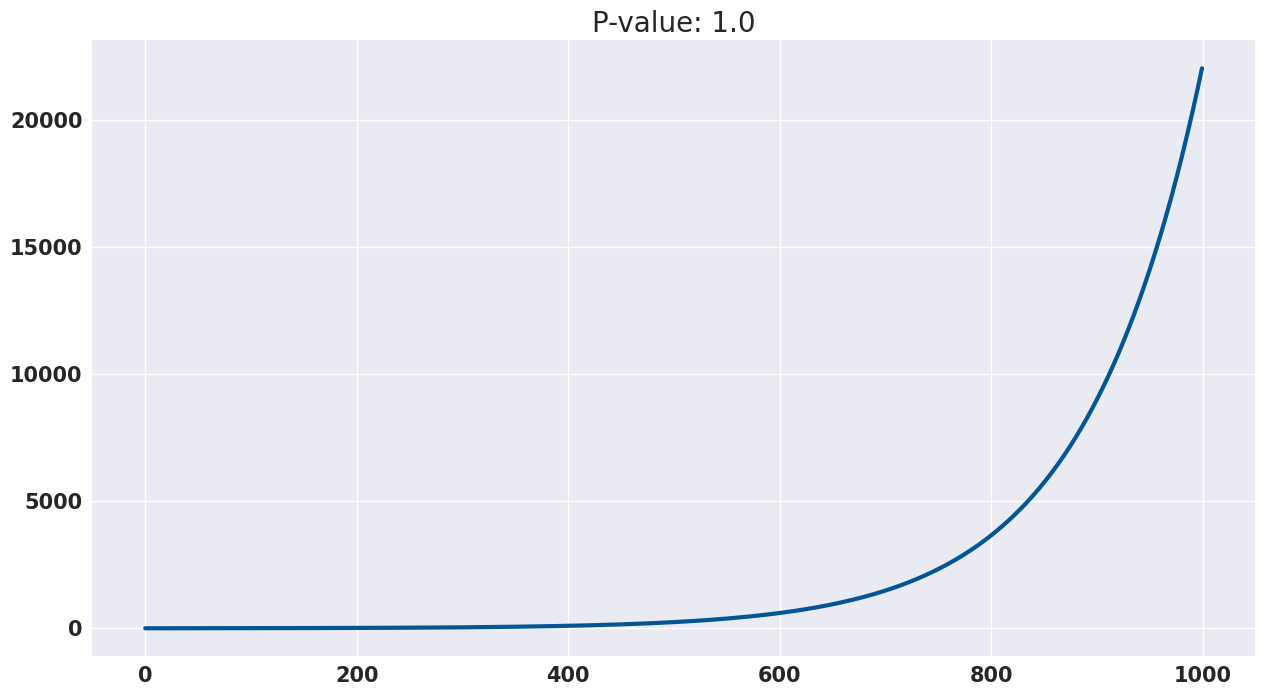

In [3]:
# Simulate time series
log = np.exp(np.linspace(1,10,1000))

# Compute the pvalue
p = adfuller(log)[1]


plt.figure(figsize=(15,8))
plt.plot(log, color="#035593", linewidth=3)
plt.title(f"P-value: {p}", size=20)
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

In [4]:
# For cointegration check
import statsmodels.api as stat


def cointegration(x, y):
    p = 0.1
    px = adfuller(x)[1]
    py = adfuller(y)[1]
    ols = stat.OLS(x, y).fit()

    residual = adfuller(ols.resid)[1]
    if residual <= p and px > p and py > p:
        return 'Cointegration'
    else:
        return 'No Cointegration'

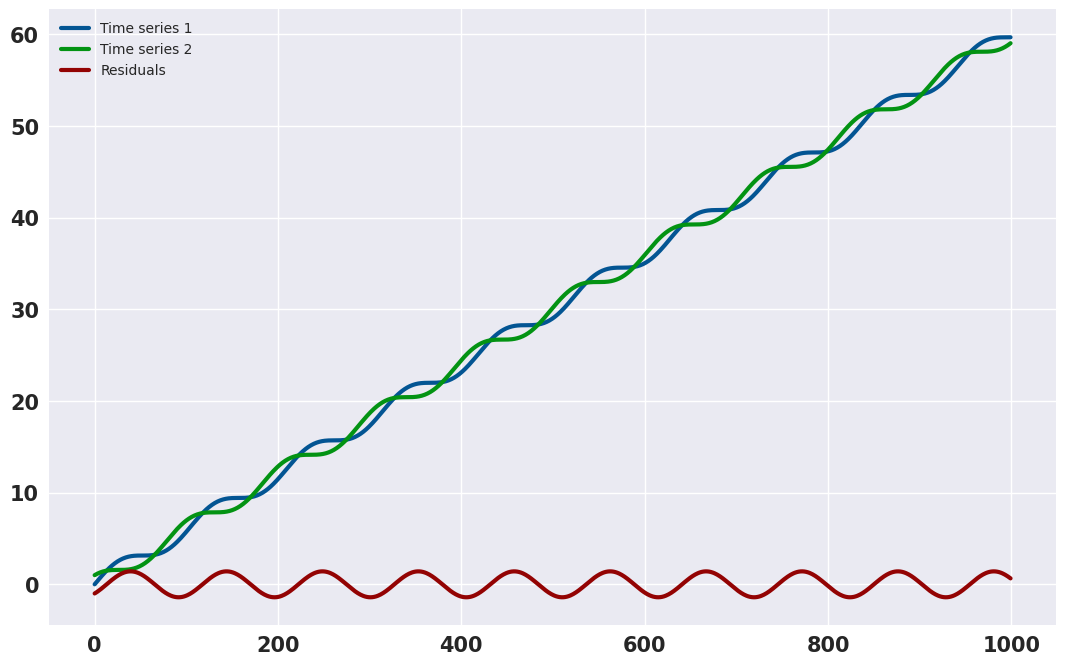

In [5]:
# Simulate the time series
numbers = np.linspace(0,60,1000)
sin = numbers + np.sin(numbers)
cos = numbers + np.cos(numbers)

plt.figure(figsize=(13,8))
plt.plot(sin, color="#035593", linewidth=3) # Ts1
plt.plot(cos, color="#039313", linewidth=3) # Ts2
plt.plot(sin-cos, color="#930303", linewidth=3) # Residuals
plt.legend(["Time series 1", "Time series 2", "Residuals"])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.show()

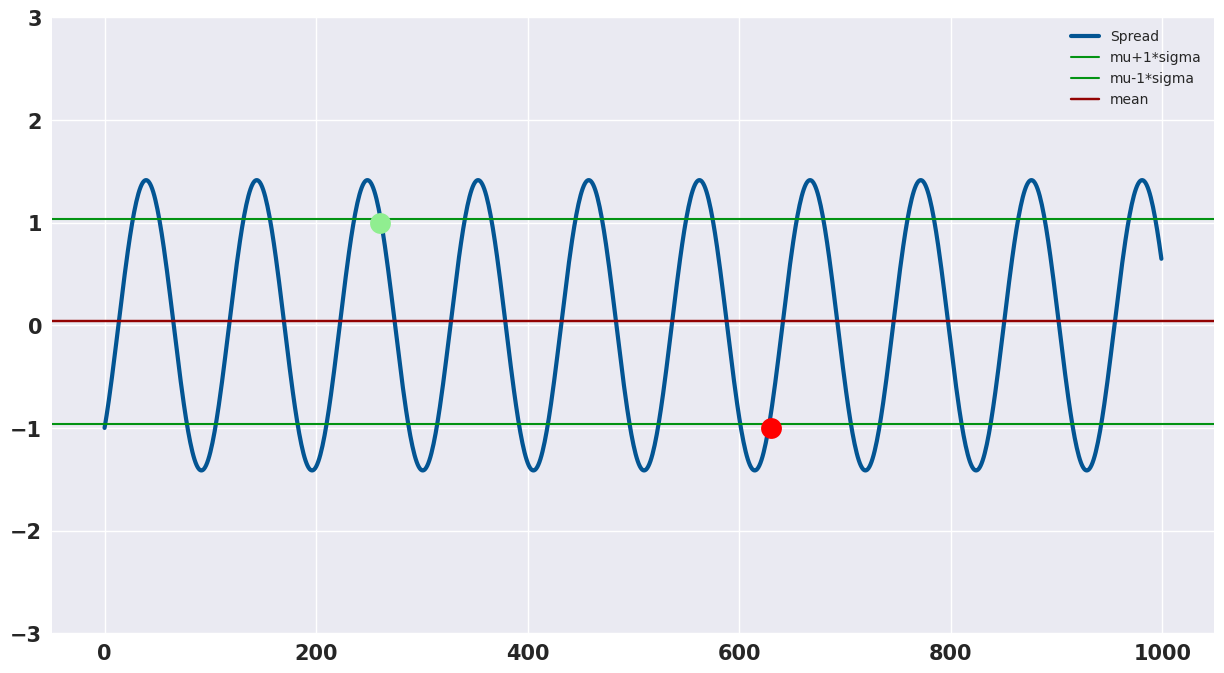

In [6]:
# Create the stars
ex_long = np.empty((len(sin),1))
ex_long[:] = np.NaN

ex_short = np.empty((len(sin),1))
ex_short[:] = np.NaN

ex_long[260] = 1
ex_short[630] = -1

# Plot the graph
plt.figure(figsize=(15,8))
plt.plot(sin-cos, color="#035593", linewidth=3)
plt.axhline((sin-cos).mean() + (sin-cos).std(), color="#039313", linewidth=1.5)
plt.axhline((sin-cos).mean() -(sin-cos).std(), color="#039313", linewidth=1.5)
plt.axhline((sin-cos).mean(), color="#930303")

plt.plot(ex_long, "o",markersize=15, color="lightgreen")
plt.plot(ex_short, "o",markersize=15, color="r")

plt.legend(["Spread", "mu+1*sigma", "mu-1*sigma", "mean"])
plt.ylim([-3,3])
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")


plt.show()

In [ ]:
currencies = [f"{currency}=X" for currency in ["USDCAD",
            "EURUSD","EURCHF", "USDCHF","EURGBP", "NZDUSD","GBPCHF",
            "EURCAD","EURAUD","AUDNZD"]]

train_set = yf.download(currencies)["Adj Close"].dropna().loc["2000":"2017"]

In [ ]:
train_set

In [ ]:
# We need to find the number of combinaison of 2 by 10
# 10! / (2!*8!) = 45

# Initialize the variables
nbc = 0
list_com = []

while nbc <45:
    # Take the assetes for the pair randomly 
    c1 = np.random.choice(currencies)
    c2 = np.random.choice(currencies)

    # Add the list of the two asset
    if c1 != c2 and [c1, c2] not in list_com and [c2, c1] not in list_com:
        list_com.append([c1,c2])
        nbc+=1

list_com

In [ ]:
# Initialize the storage variable for all row
resume = []

for com in list_com:
    # Initialize the variable
    row = []

    # Add the name of the assets in the list
    row.extend(com)

    # Add the result of the cointegration test
    row.append(cointegration(train_set[com[0]].values, train_set[com[1]].values))

    # Add the results of the correlation 
    row.append(train_set[com].pct_change(1).corr().values[0][1])

    # Add each row to do a list of list
    resume.append(row)

# Create a dataframe to a better visualization
sum = pd.DataFrame(resume,columns=["Asset1", "Asset2", "Cointegration", "Cor"])

# Filtered the row by the cointegred pair
sum.loc[sum["Cointegration"] == "Cointegration"]

In [ ]:
# Reset train test sets
test_set = yf.download(currencies)["Adj Close"].dropna().loc["2017":]
train_set = yf.download(currencies)["Adj Close"].dropna().loc["2000":"2017"]

# Define the assets using the cointegration and correlation criterion
ts1 = "EURAUD=X"
ts2 = "USDCHF=X"

# Create the percentage of variation for each time series
test_set["pct ts1"] = test_set[ts1].pct_change(1)
test_set["pct ts2"] = test_set[ts2].pct_change(1)

# Compute the difference between the two time series
train_set["spread"] = train_set[ts1]-train_set[ts2]
test_set["spread"] = test_set[ts1]-test_set[ts2]

# Compute the z-scores
test_set["z-score"] = (test_set["spread"] - train_set["spread"].mean()) / train_set["spread"].std()
train_set["z-score"] = (train_set["spread"] - train_set["spread"].mean()) / train_set["spread"].std()

# Compute the mean and the std
std_high = train_set["z-score"].std()
std_low = train_set["z-score"].std()
mean = train_set["z-score"].mean()

# Create some variables
test_set["signal_ts1"] = np.nan
test_set["signal_ts2"] = np.nan
test_set["yersteday_z-score"] = test_set["z-score"].shift(1)


# Short
test_set.loc[(test_set["z-score"]<std_high) & (test_set["yersteday_z-score"]>std_high),"signal_ts1"] = -1

# False short signal
test_set.loc[(test_set["z-score"]>std_high) & (test_set["yersteday_z-score"]<std_high),"signal_ts1"] = 0

# Long
test_set.loc[(test_set["z-score"]>std_low) & (test_set["yersteday_z-score"]<std_low),"signal_ts1"] = 1

# False long signal
test_set.loc[(test_set["z-score"]<std_low) & (test_set["yersteday_z-score"]>std_low),"signal_ts1"] = 0

# Cut long position
test_set.loc[(test_set["z-score"]<mean) & (test_set["yersteday_z-score"]>mean),"signal_ts1"] = 0

# Cut short position
test_set.loc[(test_set["z-score"]>mean) & (test_set["yersteday_z-score"]<mean),"signal_ts1"] = 0

# positions
test_set["positions_ts1"] = test_set["signal_ts1"].fillna(method='ffill').fillna(0)



# long
test_set.loc[(test_set["z-score"]<std_high) & (test_set["yersteday_z-score"]>std_high),"signal_ts2"] = 1

# False long signal
test_set.loc[(test_set["z-score"]>std_high) & (test_set["yersteday_z-score"]<std_high),"signal_ts2"] = 0

# short
test_set.loc[(test_set["z-score"]>std_low) & (test_set["yersteday_z-score"]<std_low),"signal_ts2"] = -1

# False short signal
test_set.loc[(test_set["z-score"]<std_high) & (test_set["yersteday_z-score"]>std_high),"signal_ts2"] = 0

# Cut short position
test_set.loc[(test_set["z-score"]<mean) & (test_set["yersteday_z-score"]>mean),"signal_ts2"] = 0

# Cut long position
test_set.loc[(test_set["z-score"]>mean) & (test_set["yersteday_z-score"]<mean),"signal_ts2"] = 0

# positions
test_set["positions_ts2"] = test_set["signal_ts2"].fillna(method='ffill').fillna(0)

test_set["profit_ts1"] =  (test_set["positions_ts1"].shift(1)) * test_set["pct ts1"]
test_set["profit_ts2"] =  (test_set["positions_ts1"].shift(1)) * test_set["pct ts2"]

test_set["profit"] = test_set["profit_ts1"] + test_set["profit_ts2"]

In [ ]:
from Backtest import *
backtest_dynamic_portfolio(test_set["profit"])